In [1]:
# Desenvolva um sistema de Processamento de Linguagem Natural que seja capaz de detectar 
# se um determinado SMS é normal ou spam. 
# Além de métodos simples, como floresta aleatória 
# e support vector machine (SVM), 
# use também uma long short-term memory (LSTM).

# Para essa tarefa, use a seguinte base de dados: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import requests
from io import BytesIO
from zipfile import ZipFile

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
# Define the URL of the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

# Download the data and extract the contents of the ZIP archive
response = requests.get(url)
archive = ZipFile(BytesIO(response.content))

# Load the data
df = pd.read_csv(archive.open('SMSSpamCollection'), sep='\t', names=['label', 'message'])


In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['message']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: message, Length: 5572, dtype: object

In [6]:
# TIRAR PONTUAÇÃO E CARACTERES ESPECIAIS

def limpa_texto(data, col):
    data[col] = df[col].str.lower()
    data[col] = df[col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "",x))

In [7]:
limpa_texto(df, 'message')

In [8]:
df['message']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: message, Length: 5572, dtype: object

In [9]:
# REMOVER PALAVRAS COMUNS
# SEPARANDO PALAVRAS POR VÍRGULAS

def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('english')             # REMOVER PALAVRAS COMUNS
    lista_de_lista_de_palavras = data['message'].str.split()  # SEPARANDO PALAVRAS POR VÍRGULAS
    for idx, _ in data.iterrows():
        data[col].at[idx] = [i for i in lista_de_lista_de_palavras[idx] \
                             if i not in palavras_comuns]

In [10]:
remove_palavras_comuns(df, "message")

In [11]:
df['message']

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, u, 750, poun...
5568                      [b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: message, Length: 5572, dtype: object

In [12]:
# REMOVER VARIAÇÃO DA MESMA PALAVRA

def tira_variacoes_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()    
    for idx, _ in data.iterrows():
        data[col].at[idx] = [tira_variacao.lemmatize(i, 'v') \
                             for i in data[col][idx]]

In [13]:
tira_variacoes_de_palavras(df, 'message')

In [14]:
df['message']

0       [go, jurong, point, crazy, available, bugis, n...
1                            [ok, lar, joke, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, go, usf, live, around, though]
                              ...                        
5567    [2nd, time, try, 2, contact, u, u, 750, pound,...
5568                         [b, go, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitch, act, like, id, interest, buy, som...
5571                                   [rofl, true, name]
Name: message, Length: 5572, dtype: object

In [15]:
# ENGENHARIA DE RECURSOS (FEATURE ENGINEERING)

# QUANTIDADE DE PALAVRAS POR TWEET

df['palavras'] = df['message'].apply(len)

In [16]:
df

,label,message,palavras
0,ham,"[go, jurong, point, crazy, available, bugis, n...",16
1,ham,"[ok, lar, joke, wif, u, oni]",6
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",23
3,ham,"[u, dun, say, early, hor, u, c, already, say]",9
4,ham,"[nah, dont, think, go, usf, live, around, though]",8
...,...,...,...
5567,spam,"[2nd, time, try, 2, contact, u, u, 750, pound,...",20
5568,ham,"[b, go, esplanade, fr, home]",5
5569,ham,"[pity, mood, soany, suggestions]",4
5570,ham,"[guy, bitch, act, like, id, interest, buy, som...",14


In [17]:
# ANÁLISE EXPLORATÓRIA DOS DADOS (AED)

# DISTRIBUIÇÃO DAS QUANTIDADES DE PALAVRAS POR 'LABEL'

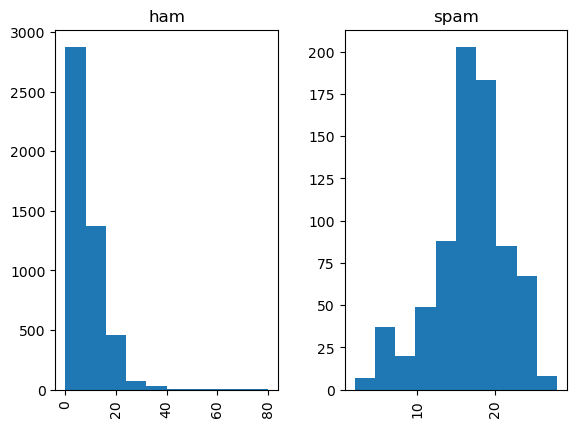

In [18]:
df.hist(column=['palavras'], by='label')
plt.show()

In [19]:
df

,label,message,palavras
0,ham,"[go, jurong, point, crazy, available, bugis, n...",16
1,ham,"[ok, lar, joke, wif, u, oni]",6
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",23
3,ham,"[u, dun, say, early, hor, u, c, already, say]",9
4,ham,"[nah, dont, think, go, usf, live, around, though]",8
...,...,...,...
5567,spam,"[2nd, time, try, 2, contact, u, u, 750, pound,...",20
5568,ham,"[b, go, esplanade, fr, home]",5
5569,ham,"[pity, mood, soany, suggestions]",4
5570,ham,"[guy, bitch, act, like, id, interest, buy, som...",14


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


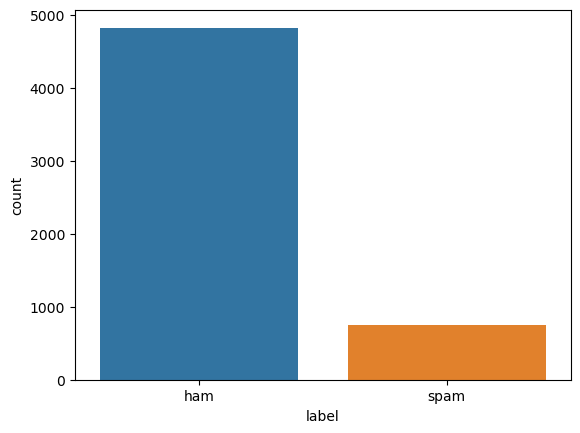

In [20]:
# QUANTIDADE DE CADA 'LABEL'

sns.countplot('label', data=df);
plt.show()

In [21]:
# PALAVRAS FREQUENTES

# AVERIGUAR PALAVRAS MAIS FREQUENTES CLASSIFICADAS COMO 'CARISTAS OU SEXISTAS'

In [22]:
df.loc[df['label']=='spam']['message']

2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
5       [freemsg, hey, darling, 3, weeks, word, back, ...
8       [winner, value, network, customer, select, rec...
9       [mobile, 11, months, u, r, entitle, update, la...
11      [six, chance, win, cash, 100, 20000, pound, tx...
                              ...                        
5537    [want, explicit, sex, 30, secs, ring, 02073162...
5540    [ask, 3mobile, 0870, chatlines, inclu, free, m...
5547    [contract, mobile, 11, mnths, latest, motorola...
5566    [reminder, o2, get, 250, pound, free, call, cr...
5567    [2nd, time, try, 2, contact, u, u, 750, pound,...
Name: message, Length: 747, dtype: object

In [23]:
lista_de_listas = df.loc[df['label']=='spam']['message'].values

In [24]:
lista_de_listas

array([list(['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', '87121', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', '08452810075over18s']),
       list(['freemsg', 'hey', 'darling', '3', 'weeks', 'word', 'back', 'id', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', '150', 'rcv']),
       list(['winner', 'value', 'network', 'customer', 'select', 'receivea', '900', 'prize', 'reward', 'claim', 'call', '09061701461', 'claim', 'code', 'kl341', 'valid', '12', 'hours']),
       list(['mobile', '11', 'months', 'u', 'r', 'entitle', 'update', 'latest', 'colour', 'mobiles', 'camera', 'free', 'call', 'mobile', 'update', 'co', 'free', '08002986030']),
       list(['six', 'chance', 'win', 'cash', '100', '20000', 'pound', 'txt', 'csh11', 'send', '87575', 'cost', '150pday', '6days', '16', 'tsandcs', 'apply', 'reply', 'hl', '4', 'info']),
       list(['urgent', '1', 'week', 'free', 'membership', '100000', 

In [25]:
[i for j in lista_de_listas for i in j] # SINTAXE PARA UMA LISTA DENTRO DE UMA LISTA

['free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'weeks',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 '150',
 'rcv',
 'winner',
 'value',
 'network',
 'customer',
 'select',
 'receivea',
 '900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hours',
 'mobile',
 '11',
 'months',
 'u',
 'r',
 'entitle',
 'update',
 'latest',
 'colour',
 'mobiles',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'co',
 'free',
 '08002986030',
 'six',
 'chance',
 'win',
 'cash',
 '100',
 '20000',
 'pound',
 'txt',
 'csh11',
 'send',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'apply',
 'reply',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'members

In [26]:
palavras = [i for j in lista_de_listas for i in j]

In [27]:
len(palavras)

12515

In [28]:
import collections

In [29]:
def gera_freq_palavras(lista):
    return collections.Counter(lista)

In [30]:
gera_freq_palavras(palavras)

Counter({'free': 216,
         'entry': 26,
         '2': 173,
         'wkly': 14,
         'comp': 10,
         'win': 62,
         'fa': 4,
         'cup': 5,
         'final': 16,
         'tkts': 4,
         '21st': 2,
         'may': 7,
         '2005': 3,
         'text': 120,
         '87121': 4,
         'receive': 37,
         'questionstd': 2,
         'txt': 150,
         'ratetcs': 2,
         'apply': 29,
         '08452810075over18s': 2,
         'freemsg': 12,
         'hey': 5,
         'darling': 2,
         '3': 26,
         'weeks': 13,
         'word': 22,
         'back': 23,
         'id': 3,
         'like': 13,
         'fun': 9,
         'still': 7,
         'tb': 1,
         'ok': 5,
         'xxx': 11,
         'std': 9,
         'chgs': 1,
         'send': 80,
         '150': 39,
         'rcv': 2,
         'winner': 16,
         'value': 11,
         'network': 27,
         'customer': 49,
         'select': 26,
         'receivea': 2,
         '900': 7,
 

In [31]:
freq_palavras = gera_freq_palavras(palavras)

In [32]:
len(freq_palavras)

2726

In [33]:
lista_de_palavras = []
lista_de_frequencias=[]
for i, j in freq_palavras.items():
    lista_de_palavras.append(i)
    lista_de_frequencias.append(j)

In [34]:
lista_de_palavras

['free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 '87121',
 'receive',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'weeks',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 '150',
 'rcv',
 'winner',
 'value',
 'network',
 'customer',
 'select',
 'receivea',
 '900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'code',
 'kl341',
 'valid',
 '12',
 'hours',
 'mobile',
 '11',
 'months',
 'u',
 'r',
 'entitle',
 'update',
 'latest',
 'colour',
 'mobiles',
 'camera',
 'co',
 '08002986030',
 'six',
 'chance',
 'cash',
 '100',
 '20000',
 'pound',
 'csh11',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'reply',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'membership',
 '100000',
 'jackpot',
 '81010',
 'tc',
 'wwwdbuknet',
 'lccltd',
 'pobox',
 '4403ldnw1a7rw18',
 'xxxmobilemoviecl

In [35]:
lista_de_frequencias

[216,
 26,
 173,
 14,
 10,
 62,
 4,
 5,
 16,
 4,
 2,
 7,
 3,
 120,
 4,
 37,
 2,
 150,
 2,
 29,
 2,
 12,
 5,
 2,
 26,
 13,
 22,
 23,
 3,
 13,
 9,
 7,
 1,
 5,
 11,
 9,
 1,
 80,
 39,
 2,
 16,
 11,
 27,
 49,
 26,
 2,
 7,
 94,
 10,
 115,
 366,
 2,
 29,
 2,
 23,
 11,
 5,
 123,
 5,
 4,
 147,
 22,
 8,
 19,
 36,
 18,
 12,
 33,
 5,
 2,
 3,
 29,
 62,
 37,
 2,
 23,
 2,
 4,
 28,
 2,
 2,
 51,
 2,
 109,
 6,
 119,
 9,
 63,
 36,
 49,
 2,
 2,
 2,
 2,
 21,
 2,
 2,
 16,
 2,
 1,
 11,
 19,
 5,
 10,
 6,
 16,
 45,
 1,
 9,
 5,
 1,
 22,
 10,
 1,
 10,
 144,
 12,
 3,
 8,
 12,
 1,
 1,
 1,
 1,
 15,
 4,
 27,
 15,
 23,
 1,
 55,
 1,
 15,
 1,
 1,
 1,
 27,
 38,
 24,
 65,
 15,
 16,
 21,
 10,
 4,
 2,
 69,
 1,
 1,
 1,
 1,
 1,
 20,
 1,
 1,
 4,
 1,
 26,
 10,
 6,
 11,
 3,
 6,
 3,
 19,
 3,
 3,
 3,
 7,
 3,
 7,
 3,
 11,
 3,
 4,
 25,
 66,
 4,
 21,
 2,
 12,
 4,
 2,
 2,
 2,
 41,
 2,
 2,
 2,
 2,
 2,
 6,
 1,
 1,
 6,
 1,
 1,
 72,
 10,
 13,
 2,
 2,
 2,
 51,
 24,
 19,
 24,
 3,
 3,
 3,
 2,
 3,
 94,
 2,
 2,
 2,
 32,
 33,
 2,
 2,
 2,
 2,
 

In [36]:
data_freq = pd.DataFrame({'palavra': lista_de_palavras, 
                          'freq': lista_de_frequencias})

In [37]:
data_freq.sort_values('freq', ascending=False, inplace=True)

In [38]:
dict(data_freq[:10].values)

{'call': 366,
 'free': 216,
 '2': 173,
 'txt': 150,
 'u': 147,
 'ur': 144,
 'mobile': 123,
 'text': 120,
 '4': 119,
 'claim': 115}

In [39]:
# NÚVEM DE PALAVRAS

from wordcloud import WordCloud

In [40]:
nuvem = WordCloud(background_color='white')

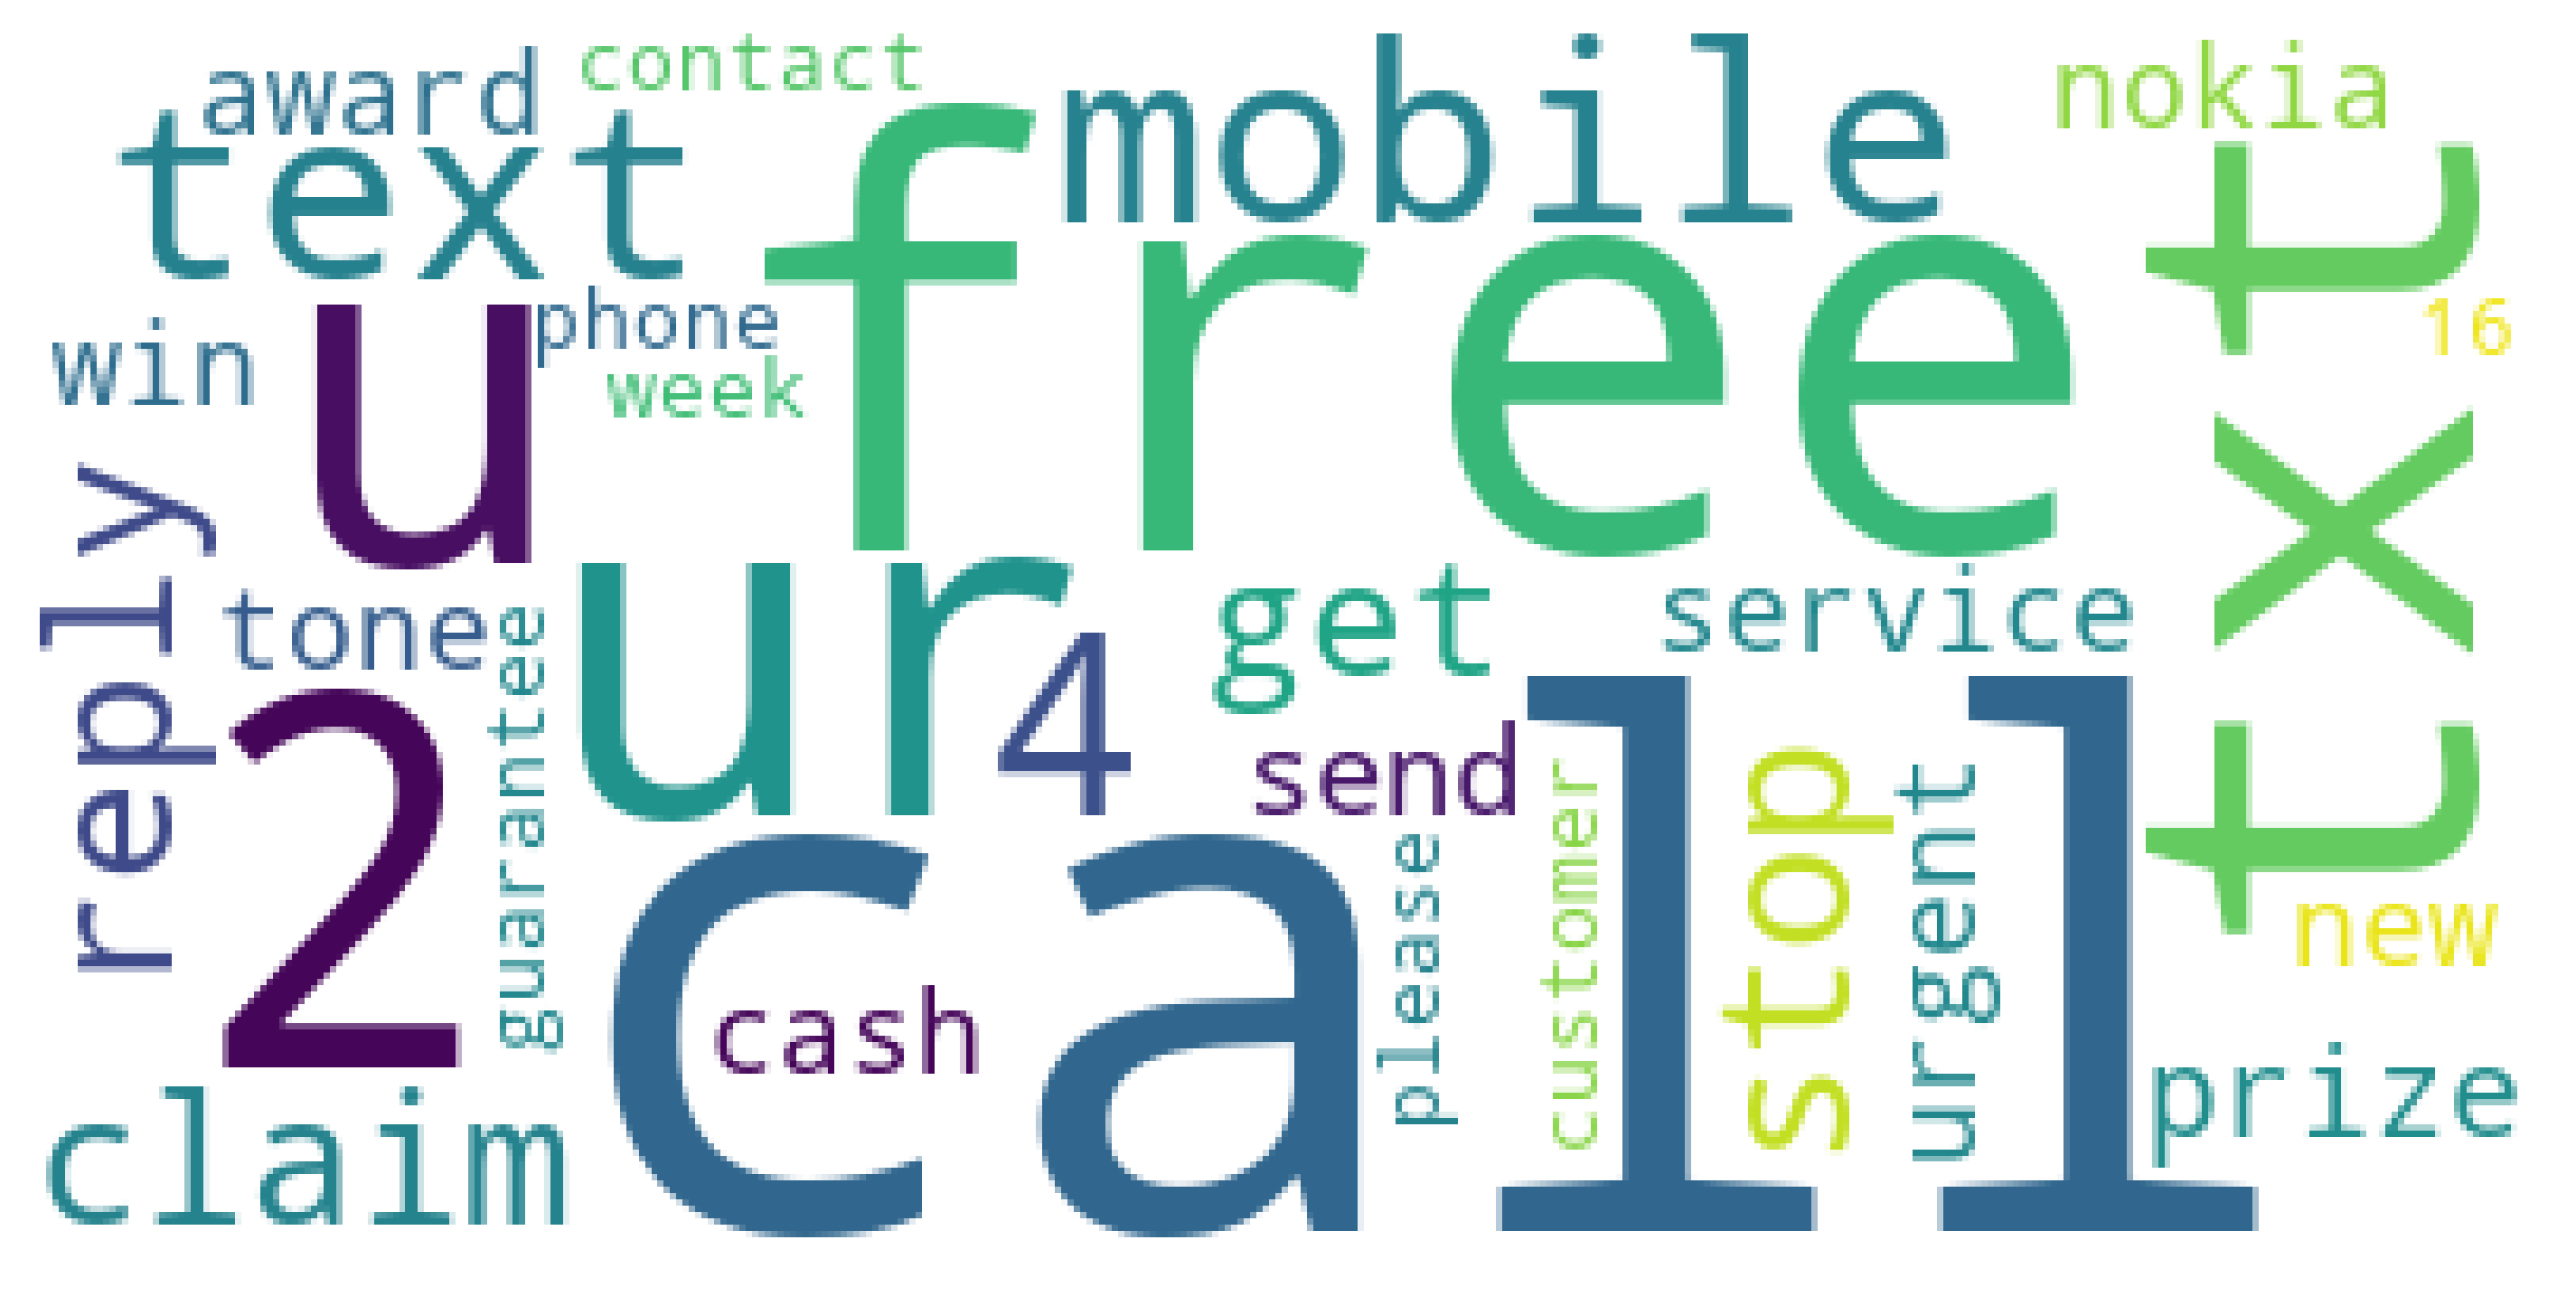

In [41]:
plt.figure(figsize=(12, 8), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq[:30].values))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

In [42]:
df['message'][7]

['per',
 'request',
 'melle',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'callers',
 'press',
 '9',
 'copy',
 'friends',
 'callertune']

In [43]:
' '.join(df['message'][7])

'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune'

In [44]:
# RETORNAR PARA FORMATO DE TEXTO

df['message'].apply(lambda x: ' '.join(x))

0       go jurong point crazy available bugis n great ...
1                                   ok lar joke wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4                nah dont think go usf live around though
                              ...                        
5567    2nd time try 2 contact u u 750 pound prize 2 c...
5568                               b go esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitch act like id interest buy something e...
5571                                       rofl true name
Name: message, Length: 5572, dtype: object

In [45]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

In [46]:
# SOLUCIONAR PROBLEMA DE DESEQUILÍBRIO DE DADOS

df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [47]:
from sklearn.utils import resample

In [48]:
df_minoria = df.loc[df['label']=='spam']

In [49]:
df_maioria = df.loc[df['label']=='ham']

In [50]:
menor_pro_maior = resample(df_minoria, 
                           replace=True, 
                           n_samples=len(df_maioria), 
                           random_state=123)

In [51]:
menor_pro_maior

,label,message,palavras
3856,spam,free msg single find partner area 1000s real p...,19
2680,spam,new tone week include 1mcflyall ab 2 sara jorg...,16
2804,spam,freemsgfav xmas tonesreply real,4
2311,spam,nokia 7250i get win free auction take part sen...,14
684,spam,hi im sue 20 years old work lapdancer love sex...,22
...,...,...,...
357,spam,congratulations ur award 500 cd vouchers 125gi...,19
2954,spam,urgent mobile award 1500 bonus caller prize 27...,15
1129,spam,ur hmv quiz cashbalance currently 500 maximize...,13
4359,spam,date service ask 2 contact u someone shy call ...,15


In [52]:
df_equilibrado = pd.concat([menor_pro_maior, df_maioria])

In [53]:
df_equilibrado

,label,message,palavras
3856,spam,free msg single find partner area 1000s real p...,19
2680,spam,new tone week include 1mcflyall ab 2 sara jorg...,16
2804,spam,freemsgfav xmas tonesreply real,4
2311,spam,nokia 7250i get win free auction take part sen...,14
684,spam,hi im sue 20 years old work lapdancer love sex...,22
...,...,...,...
5565,ham,huh lei,2
5568,ham,b go esplanade fr home,5
5569,ham,pity mood soany suggestions,4
5570,ham,guy bitch act like id interest buy something e...,14


In [54]:
def equilibra_dados(df, pra_mais=True):
    df_minoria = df.loc[df['label']=="spam"] 
    df_maioria = df.loc[df['label']=="ham"]
    if pra_mais:
        menor_pro_maior = resample(df_minoria, 
                           replace=True, 
                           n_samples=len(df_maioria), 
                           random_state=123)
        df_equilibrado = pd.concat([menor_pro_maior, df_maioria])
    else: 
        maior_pro_menor = resample(df_maioria, 
                           replace=True, 
                           n_samples=len(df_minoria), 
                           random_state=123)
        df_equilibrado = pd.concat([maior_pro_menor, df_minoria])
        
    return df_equilibrado

In [55]:
df_equilibrado = equilibra_dados(df, pra_mais=True)  # TESTAR USANDO TRUE E FALSE ***

In [56]:
# TREINAR MODELO

from sklearn.model_selection import train_test_split

In [57]:
X = df_equilibrado['message']
y = df_equilibrado['label']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [59]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [60]:
# FLORESTA ALEATÓRIA

In [61]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [62]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9971742543171115


In [63]:
# Predict new messages
def predict_message(text):
    text_vect = vectorizer.transform([text])
    prediction = clf.predict(text_vect)
    if prediction[0] == 'ham':
        return 'normal'
    else:
        return 'spam'

In [64]:
print(predict_message("Hey, what's up?"))
print(predict_message("Free viagra mobile call today!")) 
print(predict_message("freemsgfav xmas tonesreply"))

normal
normal
spam


In [65]:
y_pred

array(['spam', 'spam', 'spam', ..., 'spam', 'spam', 'ham'], dtype=object)

In [66]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

max_f1_score = 0
max_n_estimators = 0

for i in range(1, 110, 1):
    modelo = RandomForestClassifier(n_estimators=i, random_state=0)
    modelo.fit(X_train, y_train_encoded)
    
    y_pred_encoded = modelo.predict(X_test)
    
    f1 = f1_score(y_test_encoded, y_pred_encoded)
    
    if f1 > max_f1_score:
        max_f1_score = f1
        max_n_estimators = i

print(f"The maximum F1 score of {max_f1_score} was achieved with {max_n_estimators} estimators.")


The maximum F1 score of 0.9972316210396801 was achieved with 48 estimators.


In [67]:
# SUPPORT VECTOR MACHINE (SVM)

In [68]:
# Train the model

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC()

In [69]:
# Test the model
y_pred = svm.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.9974882260596546
Confusion matrix:
[[1549    6]
 [   2 1628]]
Classification report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1555
        spam       1.00      1.00      1.00      1630

    accuracy                           1.00      3185
   macro avg       1.00      1.00      1.00      3185
weighted avg       1.00      1.00      1.00      3185



In [71]:
# Predict new messages
def predict_message(text):
    text_vect = vectorizer.transform([text])
    prediction = svm.predict(text_vect)
    if prediction[0] == 'ham':
        return 'normal'
    else:
        return 'spam'

In [72]:
print(predict_message("Hey, what's up?"))
print(predict_message("Free viagra mobile call today!")) 
print(predict_message("freemsgfav xmas tonesreply real"))

normal
spam
spam


In [73]:
# LONG SHORT-TERM MEMORY (LSTM)

In [74]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [75]:
# Preprocess the data
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [76]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)


In [77]:
from keras.preprocessing.text import Tokenizer

# Convert X_train and X_test to list of strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [78]:
# Pad the sequences
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [79]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=100),
    tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [80]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [81]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
140/140 [==============================] - 7s 33ms/step - loss: 0.4196 - accuracy: 0.8609
Epoch 2/5
140/140 [==============================] - 5s 34ms/step - loss: 0.3953 - accuracy: 0.8658
Epoch 3/5
140/140 [==============================] - 5s 34ms/step - loss: 0.3947 - accuracy: 0.8658
Epoch 4/5
140/140 [==============================] - 5s 34ms/step - loss: 0.3951 - accuracy: 0.8658
Epoch 5/5
140/140 [==============================] - 5s 34ms/step - loss: 0.3959 - accuracy: 0.8658


In [82]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

35/35 [==============================] - 0s 6ms/step - loss: 0.3935 - accuracy: 0.8664
Accuracy: 0.8663676977157593


In [83]:
# Predict new messages
def predict_message(text):
    text = [text]
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, padding='post', maxlen=100)
    prediction = model.predict(text)[0]
    if prediction >= 0.5:
        return 'spam'
    else:
        return 'normal'

In [84]:
print(predict_message("Hey, what's up?"))
print(predict_message("Free viagra mobile call txt today!"))

1/1 [==============================] - 0s 170ms/step
normal
1/1 [==============================] - 0s 17ms/step
normal
